# Feed Forward Neural Network

Βήμα 1: Φόρτωση δεδομένων (mfccs)

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
from torchvision.transforms import ToTensor

class Data2(Dataset):

    def __init__(self, base_path, subset, filetype, label_mapping, transform=None, target_transform=None):

        full_path = base_path + subset + filetype
        data_path = full_path + '/X.npy'
        labels_path = full_path + '/labels.npy'
        self.samples = np.load(data_path)
        original_labels = np.load(labels_path)
        self.processed_labels = [label_mapping[label] for label in original_labels]
        self.sample_transform = transform
        self.label_transform = target_transform

    def __len__(self):
        return len(self.processed_labels)

    def __getitem__(self, index):
        audio_sample = self.samples[index]
        audio_label = self.processed_labels[index]
        if self.sample_transform:
            audio_sample = self.sample_transform(audio_sample)
        if self.label_transform:
            audio_label = self.label_transform(audio_label)
        sample = {'music': audio_sample, 'label': audio_label}
        return sample

In [ ]:
from google.colab import drive

import torch.nn as nn
import torch.nn.functional as F

drive.mount('/content/drive/')

label_mapping = {"blues" : 0, "classical" : 1 , "hiphop" : 2 , "rock_metal_hardrock" : 3}
reverse_map = {0 : "blues", 1 :"classical"  , 2 :"hiphop"  , 3 :"rock_metal_hardrock" }

train_set = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'train' , type = '/mfccs',labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )
val_set = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'val' ,type = '/mfccs', labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )
test_set = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'test' ,type = '/mfccs', labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )


train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=800, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1376)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class FNN(nn.Module):
  def __init__(self,device):
    super(FNN, self).__init__()
    self.input_layer = nn.Linear(26,128)
    self.hidden_layer = nn.Linear(128,32)
    self.output_layer = nn.Linear(32,4)
    if device == 'cpu' or torch.cuda.is_available() == False :
      self.device = torch.device('cpu')
    else :
      self.device = torch.device('cuda')

  def forward(self, x):
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    return self.output_layer(x)

In [ ]:
fnn = FNN("cpu")
fnn = fnn.to(fnn.device)
print(fnn)

FNN(
  (input_layer): Linear(in_features=26, out_features=128, bias=True)
  (hidden_layer): Linear(in_features=128, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
)


Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [ ]:
import time

def train_model_function(epochs,optimizer,loader,loss_func,model) :
  start = time.time()
  for epoch in range(epochs) :
    for i , sample in enumerate(loader) :
      optimizer.zero_grad()
      music = sample['music'].to(model.device)
      label = sample['label'].to(model.device)
      output = model(music.float())
      error = loss_func(output,label)
      print("Loss in ", i + 1,"th batch for ",epoch, "th epoch is : ",error.item())
      error.backward()
      optimizer.step()
  end = time.time()
  print("Training in",model.device, "took ",end - start," s.")
  return model

In [ ]:
!pip install torchmetrics

Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [ ]:
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

def evaluate_model_function(loader,loss_func,neural) :
  neural.eval()
  misclassifications = 0
  correct_predictions = 0
  with torch.no_grad():
    for i , sample in enumerate(loader) :
      music = sample['music'].to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music.float())
      correct_predictions += (output.argmax(1) == label).type(torch.float).sum().item()
      misclassifications += loss_func(output,label).item()

  on_average = misclassifications / len(loader.dataset)
  f1_macro = f1_score(output, label, num_classes=4, average="macro",task = "multiclass")
  accuracy = correct_predictions / len(loader.dataset) * 100
  conf = ConfusionMatrix(num_classes=4,task = "multiclass").to(neural.device)
  matrix = conf(output.argmax(1), label)

  return on_average , f1_macro , accuracy , matrix

In [ ]:

loss_func = nn.CrossEntropyLoss()

Βήμα 5: Εκπαίδευση δικτύου

In [ ]:

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fnn.parameters(), lr = 0.002)
fnn = train_model_function(30,optimizer,train_loader,loss_func,fnn)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Loss in  2 th batch for  5 th epoch is :  1.3262624740600586
Loss in  3 th batch for  5 th epoch is :  1.345271348953247
Loss in  4 th batch for  5 th epoch is :  1.3493720293045044
Loss in  5 th batch for  5 th epoch is :  1.3157544136047363
Loss in  6 th batch for  5 th epoch is :  1.3504434823989868
Loss in  7 th batch for  5 th epoch is :  1.3337156772613525
Loss in  8 th batch for  5 th epoch is :  1.2275840044021606
Loss in  9 th batch for  5 th epoch is :  1.304648756980896
Loss in  10 th batch for  5 th epoch is :  1.2476491928100586
Loss in  11 th batch for  5 th epoch is :  1.287427306175232
Loss in  12 th batch for  5 th epoch is :  1.2972526550292969
Loss in  13 th batch for  5 th epoch is :  1.277016520500183
Loss in  14 th batch for  5 th epoch is :  1.3113763332366943
Loss in  15 th batch for  5 th epoch is :  1.367456078529358
Loss in  16 th batch for  5 th epoch is :  1.3132340908050537
Loss in  17 th batch for  5 

In [ ]:

loss , f1 , acc , conf_matrix = evaluate_model_function(test_loader,loss_func,fnn)
print("Model presents average loss :",loss)
print("Model has f1 macro averaged score :",f1.item())
print("Model has accuracy score :",acc)
print("Model has confusion matrix :\n",conf_matrix)

Model presents average loss : 0.0007161474678405496
Model has f1 macro averaged score : 0.5544472336769104
Model has accuracy score : 57.77616279069767
Model has confusion matrix :
 tensor([[ 78,  61,  43, 142],
        [ 13, 265,   5,  14],
        [ 88,  39, 169,  60],
        [ 22,  67,  27, 283]])


Βήμα 6: Εκπαίδευση δικτύου με GPU

In [ ]:
train_set2 = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'train' , type = '/mfccs',labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )
val_set2 = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'val' ,type = '/mfccs', labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )
test_set2 = Data2(default_path = '/content/drive/MyDrive/ML2/music_genre_data_di/', to_set = 'test' ,type = '/mfccs', labels_dict = label_mapping,transform=torch.tensor,target_trans = torch.tensor )

train_loader_gpu = DataLoader(train_set2, batch_size=16, shuffle=True)
val_loader_gpu = DataLoader(val_set2, batch_size=800, shuffle=True)
test_loader_gpu = DataLoader(test_set2, batch_size=1376)

fnnGPU = FNN('gpu')
fnnGPU = fnnGPU.to(fnnGPU.device)
fnnGPU = train_model_function(30,optimizer,train_loader_gpu,loss_func,fnnGPU)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Loss in  2 th batch for  5 th epoch is :  1.8668110370635986
Loss in  3 th batch for  5 th epoch is :  1.4865798950195312
Loss in  4 th batch for  5 th epoch is :  1.7433254718780518
Loss in  5 th batch for  5 th epoch is :  1.7523422241210938
Loss in  6 th batch for  5 th epoch is :  1.6747636795043945
Loss in  7 th batch for  5 th epoch is :  1.709775686264038
Loss in  8 th batch for  5 th epoch is :  1.6515450477600098
Loss in  9 th batch for  5 th epoch is :  1.4897116422653198
Loss in  10 th batch for  5 th epoch is :  1.6609830856323242
Loss in  11 th batch for  5 th epoch is :  1.5647746324539185
Loss in  12 th batch for  5 th epoch is :  1.2480535507202148
Loss in  13 th batch for  5 th epoch is :  1.6567679643630981
Loss in  14 th batch for  5 th epoch is :  1.4101496934890747
Loss in  15 th batch for  5 th epoch is :  1.2828483581542969
Loss in  16 th batch for  5 th epoch is :  1.818876028060913
Loss in  17 th batch for 

Βήμα 7: Επιλογή μοντέλου

In [ ]:


def train_model_function2(epochs,optimizer,train_loader,val_loader,loss_func,neural) :

  best_score = -1
  for epoch in range(epochs) :
    for i , sample in enumerate(train_loader) :
      optimizer.zero_grad()
      music = sample['music'].to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music.float())
      error = loss_func(output,label)
      error.backward()

      optimizer.step()
    loss , f1 , acc , conf_matrix = evaluate_model_function(val_loader,loss_func,neural)

    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  print("Best model is in epoch :",best_epoch)

  return wanted

In [ ]:
best_model = train_model_function2(30,optimizer,train_loader,val_loader,loss_func,fnn)
loss , f1 , acc , conf_matrix = evaluate_model_function(test_loader,loss_func,best_model)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

Best model is in epoch : 20
Best model presents average loss : 0.0006823989800935567
Best model has f1 macro averaged score : 0.5800535678863525
Best model has accuracy score : 61.70058139534884
Best model has confusion matrix :
 tensor([[ 45,  27,  62, 190],
        [ 19, 228,   6,  44],
        [ 32,  12, 241,  71],
        [  4,  24,  36, 335]])


Το καλύτερο αποτελεσμα γινεται για 20 εποχές οποτε δεν χρειάζεται να πάμε στις 30 γιατί ισως αρχίσει το overfitting. Στην CPU έτρεχε σε 80 δευτερόλεπτα και στη GPU 21 δευτερόλεπτα

# Convolutional Neural Network

Βήμα 1: Φόρτωση δεδομένων

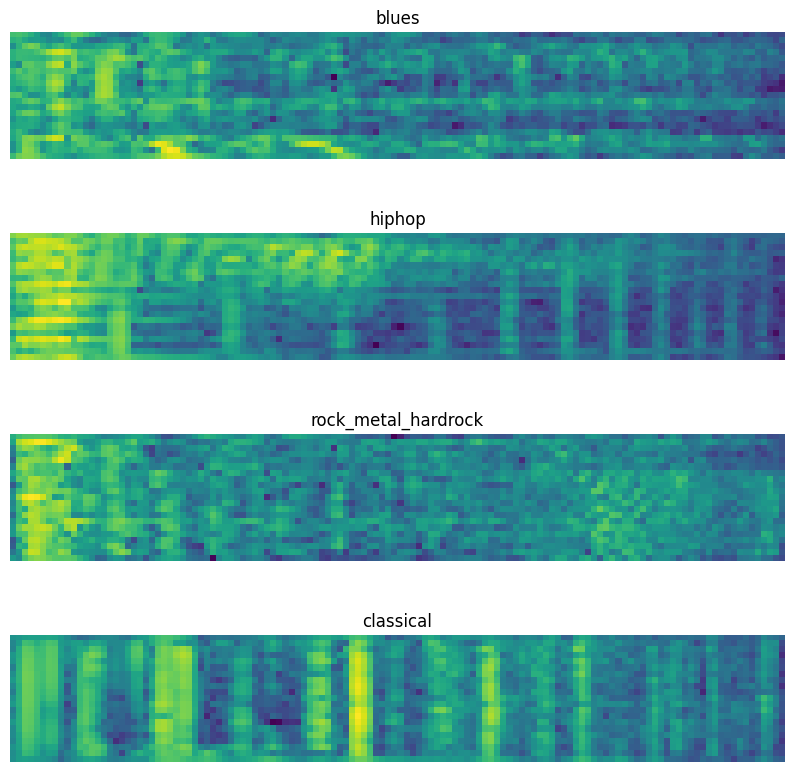

In [ ]:
import matplotlib.pyplot as plt

train_mel_spec = Data2(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'train' , type = '/melgrams',labels_dict = label_mapping,transform=torch.tensor )
val_mel_spec = Data2(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'val' ,type = '/melgrams', labels_dict = label_mapping,transform=torch.tensor )
test_mel_spec = Data2(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'test' ,type = '/melgrams', labels_dict = label_mapping,transform=torch.tensor )


figure = plt.figure(figsize=(10, 10))
cols, rows = 1, 4
classes = 0
visualized = []
while (classes < 4):
    sample_idx = torch.randint(len(train_mel_spec), size=(1,)).item()
    sample = train_mel_spec[sample_idx]
    if(sample['label'] not in visualized) :
      classes+=1
      visualized.append(sample['label'])
      figure.add_subplot(rows, cols, classes)
      plt.title(reverse_map[sample['label']])
      plt.axis("off")
      plt.imshow(sample['music'].squeeze())
plt.show()
train_l_mel_spec = DataLoader(train_mel_spec, batch_size=16, shuffle=True)
val_l_mel_spec = DataLoader(val_mel_spec, batch_size=800, shuffle=True)
test_l_mel_spec = DataLoader(test_mel_spec, batch_size=1376)


Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class CNN(nn.Module):

  def __init__(self,device):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(1,16,5)
    self.conv2 = nn.Conv2d(16,32,5)
    self.conv3= nn.Conv2d(32,64,5)
    self.conv4 = nn.Conv2d(64,128,5)
    self.input_layer = nn.Linear(71680,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)
    if device == 'cpu' or torch.cuda.is_available() == False :
      self.device = torch.device('cpu')
    else :
      print("GPU IS USED")
      self.device = torch.device('cuda')

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.flatten(x, 1)
    x = self.input_layer(x)
    x = self.hidden_1(x)
    x = self.hidden_2(x)
    return self.output(x)



In [ ]:
cnn = CNN("cpu")
cnn = cnn.to(cnn.device)
print(cnn)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (input_layer): Linear(in_features=71680, out_features=1024, bias=True)
  (hidden_1): Linear(in_features=1024, out_features=256, bias=True)
  (hidden_2): Linear(in_features=256, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=4, bias=True)
)


Βήμα 3: Εκπαίδευση δικτύου

In [ ]:
def evaluate_model_function(loader,loss_func,neural) :
  neural.eval()
  misclassifications = 0
  correct_predictions = 0
  with torch.no_grad():
    for i , sample in enumerate(loader) :
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music)
      correct_predictions += (output.argmax(1) == label).type(torch.float).sum().item()
      misclassifications += loss_func(output,label).item()

  on_average = misclassifications / len(loader.dataset)
  f1_macro = f1_score(output, label, num_classes=4, average="macro",task = "multiclass")
  accuracy = correct_predictions / len(loader.dataset) * 100
  conf = ConfusionMatrix(num_classes=4,task = "multiclass").to(neural.device)
  matrix = conf(output.argmax(1), label)
  return on_average , f1_macro , accuracy , matrix

In [ ]:

def train_model_function2(epochs,optimizer,train_loader,val_loader,loss_func,neural) :
  neural.train()
  best_score = -1
  for epoch in range(epochs) :
    print(" Epoch number is %d",epoch)
    for i , sample in enumerate(train_loader) :
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music)
      error = loss_func(output,label)
      error.backward()
      optimizer.step()
    loss , f1 , acc , conf_matrix = evaluate_model_function(val_loader,loss_func,neural)
    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  return wanted,best_epoch

In [ ]:
optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
start = time.time()
best_model,best_epoch = train_model_function2(5,optimizer,train_l_mel_spec,val_l_mel_spec,loss_func,cnn)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
Training with validation in CNN took  1323.2198739051819  s.
Best model is in epoch : 3
Best model presents average loss : 18.861308253088662
Best model has f1 macro averaged score : 0.2467218041419983
Best model has accuracy score : 31.90406976744186
Best model has confusion matrix :
 tensor([[  1, 138,  38, 147],
        [  0, 251,   7,  39],
        [  0, 166,  41, 149],
        [  0, 162,  91, 146]])


Το συγκεκριμενο για 5 εποχες αργεί πολυ (20 λεπτα) οποτε για 30 εποχές δεν μπορούσα να το επιχειρησω καν

In [ ]:
cnn = CNN("gpu")
cnn = cnn.to(cnn.device)
print(cnn)
optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
start = time.time()
best_model,best_epoch = train_model_function2(30,optimizer,train_l_mel_spec,val_l_mel_spec,loss_func,cnn)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

GPU IS USED
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (input_layer): Linear(in_features=71680, out_features=1024, bias=True)
  (hidden_1): Linear(in_features=1024, out_features=256, bias=True)
  (hidden_2): Linear(in_features=256, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=4, bias=True)
)
Training with validation in CNN took  182.93819904327393  s.
Best model is in epoch : 29
Best model presents average loss : 1.754726676053779
Best model has f1 macro averaged score : 0.5176926255226135
Best model has accuracy score : 51.59883720930233
Best model has confusion matrix :
 tensor([[132,  48, 104,  40],
        [ 45, 211,  37,   4],
        [ 86,  29, 233,   8],
        [153,  41,  71, 134]], device='cuda:0')


Παρατηρούμε ότι με τη χρήση της GPU η εκπαίδευση τελείωνει περίπου στα 3 λεπτά  και για 30 εποχές. Επίσης πριν στο FNN η χρηση GPU και CPU δεν είχε ουσιαστική διαφορα στον χρονο ενω τωρα η διαφορα ειναι τεραστια.  Ένα feedforward neural network γενικά περιλαμβάνει πιο απλές λειτουργίες ανά επίπεδο (π.χ., γραμμικοί μετασχηματισμοί και στοιχειώδεις μη γραμμικότητες). Αυτό σημαίνει ότι απαιτούνται λιγότεροι υπολογιστικοί πόροι ανά εποχή.Τα CNN χρησιμοποιούν συνελικτικά επίπεδα τα οποία είναι πολύ πιο πολύπλοκα σε σχέση με τα επίπεδα των FNN.

Βήμα 4: Pooling and padding

In [ ]:

class CNN_PP(nn.Module):

  def __init__(self):
    super(CNN_PP,self).__init__()


    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)

    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)
    self.device = torch.device('cpu')

  def forward(self, x):
    x = F.max_pool2d(self.conv1(x),kernel_size=2)
    x = F.max_pool2d(self.conv2(x),kernel_size=2)
    x = F.max_pool2d(self.conv3(x),kernel_size=2)
    x = F.max_pool2d(self.conv4(x),kernel_size=2)
    x = torch.flatten(x, 1)
    x = self.input_layer(x)
    x = self.hidden_1(x)
    x = self.hidden_2(x)
    return self.output(x)

In [ ]:
cnn_pool = CNN_PP()
cnn_pool = cnn_pool.to(cnn_pool.device)

In [ ]:

cnn_pp = cnn_pool
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(cnn_pp.parameters(), lr = 0.02)
best_model , best_epoch = train_model_function2(5,optimizer,train_l_mel_spec,val_l_mel_spec,loss_func,cnn_pp)
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
Best model is in epoch : 4
Best model presents average loss : 2.116949746775073
Best model has f1 macro averaged score : 0.3803120255470276
Best model has accuracy score : 44.11337209302326
Best model has confusion matrix :
 tensor([[  0,  13, 196, 115],
        [  0, 125, 118,  54],
        [  0,   4, 303,  49],
        [  0,   7, 213, 179]])


Ο χρόνος εκπαιδευσης γινεται 10 λεπτα αντι για 20

Βήμα 5: Activation functions

In [ ]:

import torch.nn as nn
class CNN_PP1(nn.Module):

  def __init__(self):
    super(CNN_PP1,self).__init__()
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2)
    x = torch.flatten(x, 1)
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

In [ ]:
import torch
import time
cnn_pp = CNN_PP1()
cnn_pp = cnn_pp.to(cnn_pp.device)

start = time.time()
optimizer = torch.optim.Adagrad(cnn_pp.parameters(), lr = 0.02)
best_model , best_epoch = train_model_function2(5,optimizer,train_l_mel_spec,val_l_mel_spec,loss_func,cnn_pp)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
Training with validation in CNN took  592.0519313812256  s.
Best model is in epoch : 2
Best model presents average loss : 0.0005270846967780313
Best model has f1 macro averaged score : 0.6887860894203186
Best model has accuracy score : 69.62209302325581
Best model has confusion matrix :
 tensor([[126,  23,  77,  98],
        [ 39, 248,   8,   2],
        [ 29,   5, 288,  34],
        [ 47,   8,  48, 296]])


In [ ]:

import torch.nn as nn
class CNN_PP2(nn.Module):

  def __init__(self):
    super(CNN_PP2,self).__init__()
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)
    if torch.cuda.is_available() == False :
      self.device = torch.device('cpu')
    else :
      print("GPU IS USED IN 2")
      self.device = torch.device('cuda')

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2)
    x = torch.flatten(x, 1)
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

Η εκπαιδευση με padding και pooling οχι μονο μειωνει τον χρονο εκτελεσης αλλα και αυξανει το accuracy ειδικα οταν συνδυαζεται με την RELU.Το pooling μειώνει τις διαστασεις του feature map, διατηρωντας τα βασικα χαρακτηριστικα και μειωνοντας τον αριθμο των παραμετρων κραταει αυτα με μεγαλυτερο correlation. Αυτο οδηγει σε ταχυτερη εκπαιδευση του μοντελου.Το padding προσθετει τιμες (συνηθως μηδενικα) γυρω απο τις ακρες της εικονας, βοηθωντας το μοντελο να διατηρησει τις αρχικες διαστασεις του feature map και να εξετασει καλυτερα τα δεδομενα κατα τη συνελιξη.

In [ ]:
cnn_p = CNN_PP2()
cnn_p = cnn_p.to(cnn_p.device)

GPU IS USED IN 2


In [ ]:
cnn_p = cnn_pp2

In [ ]:

import time
start = time.time()
optimizer = torch.optim.Adagrad(cnn_p.parameters(), lr = 0.02)
best_model , best_epoch = train_model_function2(5,optimizer,train_l_mel_spec,val_l_mel_spec,loss_func,cnn_p)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",conf_matrix)

 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
Training with validation in CNN took  9.137073993682861  s.
Best model is in epoch : 4
Best model presents average loss : 0.0006656137316725975
Best model has f1 macro averaged score : 0.5936390161514282
Best model has accuracy score : 60.537790697674424
Best model has confusion matrix :
 tensor([[121,  87,  67,  49],
        [ 13, 281,   3,   0],
        [ 41,  39, 268,   8],
        [135,  31,  70, 163]], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# Improving Performance - 3o Ερώτημα

Reproducibility

In [ ]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import ConfusionMatrix
import time
import torch.cuda

seed = 0


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def torch_seed(seed=0):
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

def evaluate_model_function(loader, loss_func, neural, device):
    neural.eval()
    misclassifications = 0
    correct_predictions = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for sample in loader:
            music = torch.unsqueeze(sample['music'], 1)
            music = music.to(device)
            label = sample['label'].to(device)
            output = neural(music)
            correct_predictions += (output.argmax(1) == label).type(torch.float).sum().item()
            misclassifications += loss_func(output, label).item()
            y_true.append(label)
            y_pred.append(output.argmax(1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    on_average = misclassifications / len(loader.dataset)
    f1_macro = f1_score(y_true.cpu(), y_pred.cpu(), average='macro')
    accuracy = correct_predictions / len(loader.dataset) * 100
    conf = ConfusionMatrix(num_classes=4, task='multiclass').to(device)
    matrix = conf(y_pred, y_true)
    return on_average, f1_macro, accuracy, matrix

def train_model_function2(epochs, optimizer, train_loader, val_loader, loss_func, neural, device, reproducibility=True):
    best_score = -1
    best_epoch = -1
    for epoch in range(epochs):
        print("Epoch number is %d" % epoch)
        neural.train()
        epoch_loss = 0.0
        for sample in train_loader:
            optimizer.zero_grad()
            music = torch.unsqueeze(sample['music'], 1)
            music = music.to(device)
            label = sample['label'].to(device)
            output = neural(music)
            error = loss_func(output, label)
            epoch_loss += error.item()
            error.backward()
            optimizer.step()
        epoch_loss /= len(train_loader)
        print("Training Loss: {:.4f}".format(epoch_loss))

        val_loss, f1, acc, conf_matrix = evaluate_model_function(val_loader, loss_func, neural, device)
        print("Validation Loss: {:.4f}, F1 Score: {:.4f}, Accuracy: {:.2f}%".format(val_loss, f1, acc))
        if f1 > best_score:
            best_model = neural.state_dict()
            best_score = f1
            best_epoch = epoch

    neural.load_state_dict(best_model)
    return neural, best_epoch

class CNN_PP1(nn.Module):
    def __init__(self):
        super(CNN_PP1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=5)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=5)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=5)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=5)
        self.input_layer = nn.Linear(9984, 1024)
        self.hidden_1 = nn.Linear(1024, 256)
        self.hidden_2 = nn.Linear(256, 32)
        self.output = nn.Linear(32, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        return self.output(x)

if __name__ == "__main__":
    torch_seed(seed=0)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_l_mel_spec = DataLoader(train_mel_spec, batch_size=16, shuffle=True,worker_init_fn=seed_worker)
    val_l_mel_spec = DataLoader(val_mel_spec, batch_size=800, shuffle=True,worker_init_fn=seed_worker)
    test_l_mel_spec = DataLoader(test_mel_spec, batch_size=1376,worker_init_fn=seed_worker)
    start = time.time()
    cnn_pp = CNN_PP1().to(device)
    optimizer = torch.optim.Adagrad(cnn_pp.parameters(), lr=0.02)
    best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_pp, device, reproducibility=True)
    end = time.time()
    print("Training with reproducibility in CNN took ", end - start, " s.")
    loss, f1, acc, conf_matrix = evaluate_model_function(test_l_mel_spec, loss_func, best_model, device)
    print("Test Results with reproducibility: Loss = {:.4f}, F1 Score = {:.4f}, Accuracy = {:.2f}%, Confusion Matrix = \n{}".format(loss, f1, acc, conf_matrix.cpu().numpy()))




Epoch number is 0
Training Loss: 5091.7707
Validation Loss: 0.0014, F1 Score: 0.5618, Accuracy: 58.38%
Epoch number is 1
Training Loss: 0.9264
Validation Loss: 0.0011, F1 Score: 0.6084, Accuracy: 62.25%
Epoch number is 2
Training Loss: 0.7908
Validation Loss: 0.0010, F1 Score: 0.6733, Accuracy: 68.00%
Epoch number is 3
Training Loss: 0.7406
Validation Loss: 0.0012, F1 Score: 0.6007, Accuracy: 61.88%
Epoch number is 4
Training Loss: 0.6958
Validation Loss: 0.0011, F1 Score: 0.6296, Accuracy: 63.88%
Epoch number is 5
Training Loss: 0.6738
Validation Loss: 0.0009, F1 Score: 0.7068, Accuracy: 70.50%
Epoch number is 6
Training Loss: 0.6559
Validation Loss: 0.0009, F1 Score: 0.7031, Accuracy: 69.88%
Epoch number is 7
Training Loss: 0.6395
Validation Loss: 0.0011, F1 Score: 0.6368, Accuracy: 64.62%
Epoch number is 8
Training Loss: 0.6228
Validation Loss: 0.0009, F1 Score: 0.7044, Accuracy: 70.50%
Epoch number is 9
Training Loss: 0.6032
Validation Loss: 0.0009, F1 Score: 0.7181, Accuracy: 71.3

Δυστυχώς το notebook που παραθεσατε στην εκφώνηση μου έβγαζε ότι δεν είναι διαθέσιμο οπότε συμβουλεύτηκα αυτό εδώ https://github.com/pytorch/pytorch/issues/7068

Βήμα 2: Αλγόριθμοι βελτιστοποίησης

In [ ]:
  device = torch.device('cuda')
  Adadelta = CNN_PP2().to(device)
  optimizer = torch.optim.Adadelta(Adadelta.parameters(), lr = 0.02)
  best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, Adadelta)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("Adadelta presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adagrad = CNN_PP2().to(device)
  optimizer = torch.optim.Adagrad(Adagrad.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, Adagrad)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("Adagrad presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adam = CNN_PP2().to(device)
  optimizer = torch.optim.Adam(Adam.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, Adam)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("Adam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  AdamW = CNN_PP2().to(device)
  optimizer = torch.optim.AdamW(AdamW.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, AdamW)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("AdamW presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adamax = CNN_PP2().to(device)
  optimizer = torch.optim.Adamax(Adamax.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, Adamax)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("Adamax presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  ASGD = CNN_PP2().to(device)
  optimizer = torch.optim.ASGD(ASGD.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, ASGD)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("ASGD presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  NAdam = CNN_PP2().to(device)
  optimizer = torch.optim.NAdam(NAdam.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, NAdam)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("NAdam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  RAdam = CNN_PP2().to(device)
  optimizer = torch.optim.RAdam(RAdam.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, RAdam)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("RAdam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  RMSprop = CNN_PP2().to(device)
  optimizer = torch.optim.RMSprop(RMSprop.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, RMSprop)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("RMSprop presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Rprop = CNN_PP2().to(device)
  optimizer = torch.optim.Rprop(Rprop.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, Rprop)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("Rprop presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  SGD = CNN_PP2().to(device)
  optimizer = torch.optim.SGD(SGD.parameters(), lr = 0.02)
  best_model, best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, SGD)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model)
  print("SGD presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

GPU IS USED IN 2
 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is %d 8
 Epoch number is %d 9
 Epoch number is %d 10
 Epoch number is %d 11
 Epoch number is %d 12
 Epoch number is %d 13
 Epoch number is %d 14
 Epoch number is %d 15
 Epoch number is %d 16
 Epoch number is %d 17
 Epoch number is %d 18
 Epoch number is %d 19
 Epoch number is %d 20
 Epoch number is %d 21
 Epoch number is %d 22
 Epoch number is %d 23
 Epoch number is %d 24
 Epoch number is %d 25
 Epoch number is %d 26
 Epoch number is %d 27
 Epoch number is %d 28
 Epoch number is %d 29
Adadelta presents accuracy  68.53197674418605  and f1-score  0.6994931101799011  in epoch  26
GPU IS USED IN 2
 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is

Παρατηρουμε οτι η Adagrad δουλευει καλυτερα απο ολα για αυτο σε ολο το notebook την χρησιμοποιω. Ομως βλεπουμε οτι ο λαθος optimizer μπορει να οδηγησει στο μοντελο να κανει πολλα misclassifications

| Model    | Accuracy  | F1-Score | Epoch |
|----------|-----------|----------|-------|
| Adadelta | 68.531977 | 0.699493 | 26    |
| Adagrad  | 72.238372 | 0.726544 | 10    |
| Adam     | 23.546512 | 0.095294 | 0     |
| AdamW    | 25.872093 | 0.102771 | 0     |
| Adamax   | 25.872093 | 0.102771 | 0     |
| ASGD     | 68.968023 | 0.687316 | 21    |
| NAdam    | 23.546512 | 0.095294 | 0     |
| RAdam    | 23.546512 | 0.095294 | 0     |
| RMSprop  | 21.584302 | 0.088763 | 3     |
| Rprop    | 60.392442 | 0.605589 | 24    |
| SGD      | 71.875000 | 0.723377 | 29    |


Βήμα 3: Batch Normalization

In [ ]:
class CNN_BATCH(nn.Module):

  def __init__(self):
    super(CNN_BATCH,self).__init__()
    self.batch1 = nn.BatchNorm2d(1)
    self.batch2 = nn.BatchNorm2d(16)
    self.batch3 = nn.BatchNorm2d(32)
    self.batch4 = nn.BatchNorm2d(64)
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(self.batch1(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv2(self.batch2(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv3(self.batch3(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv4(self.batch4(x))),kernel_size=2)

    x = torch.flatten(x, 1)

    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

In [ ]:

cnn_batch = CNN_BATCH().to('cuda')
optimizer = torch.optim.Adagrad(cnn_batch.parameters(), lr = 0.02)
best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_batch, device, reproducibility=True)
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model,device)
print("Model with batch is in epoch :",best_epoch)
print("Model with batch presents average loss :",loss)
print("Model with batch has f1 macro averaged score :",f1.item())
print("Model with batch has accuracy score :",acc)
print("Model with batch has confusion matrix :\n",conf_matrix)

cnn = CNN_PP1().to('cuda')
optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn, device, reproducibility=True)
loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model,device)
print("Model without batch is in epoch :",best_epoch)
print("Model without batch presents average loss :",loss)
print("Model without batch has f1 macro averaged score :",f1.item())
print("Model without batch has accuracy score :",acc)
print("Model without batch has confusion matrix :\n",conf_matrix)

Epoch number is 0
Training Loss: 2.5352
Validation Loss: 0.0012, F1 Score: 0.5372, Accuracy: 60.25%
Epoch number is 1
Training Loss: 0.8513
Validation Loss: 0.0010, F1 Score: 0.6853, Accuracy: 67.88%
Epoch number is 2
Training Loss: 0.7003
Validation Loss: 0.0009, F1 Score: 0.7075, Accuracy: 71.00%
Epoch number is 3
Training Loss: 0.5990
Validation Loss: 0.0008, F1 Score: 0.7506, Accuracy: 75.12%
Epoch number is 4
Training Loss: 0.5466
Validation Loss: 0.0008, F1 Score: 0.7514, Accuracy: 75.25%
Epoch number is 5
Training Loss: 0.5079
Validation Loss: 0.0008, F1 Score: 0.7524, Accuracy: 75.62%
Epoch number is 6
Training Loss: 0.4761
Validation Loss: 0.0007, F1 Score: 0.8115, Accuracy: 81.00%
Epoch number is 7
Training Loss: 0.4591
Validation Loss: 0.0007, F1 Score: 0.7842, Accuracy: 78.62%
Epoch number is 8
Training Loss: 0.4288
Validation Loss: 0.0007, F1 Score: 0.7824, Accuracy: 78.38%
Epoch number is 9
Training Loss: 0.4073
Validation Loss: 0.0007, F1 Score: 0.7882, Accuracy: 78.88%


Βήμα 4: Regularization

I. Weight Decay στον Optimizer

In [ ]:

def function_w_Decay(wd , epochs) :

  cnn_batch = CNN_BATCH().to(device)
  optimizer = torch.optim.Adagrad(cnn_batch.parameters(), lr = 0.02 , weight_decay= wd)
  best_model , best_epoch = train_model_function2(epochs, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_batch, device, reproducibility=True)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model,device)
  print("Model without dropout and  weight decay =", wd," is in epoch :",best_epoch)
  print("Model without dropout and  weight decay = ", wd,"presents average loss for",epochs,"epochs :",loss)
  print("Model without dropout and  weight decay =", wd," has f1 macro averaged score for",epochs,"epochs :",f1.item())
  print("Model without dropout and  weight decay = ", wd," has accuracy score for",epochs,"epochs :",acc)
  print("Model without dropout and  weight decay = ", wd," has confusion matrix for",epochs,"epochs :\n",conf_matrix)

In [ ]:
#https://www.quora.com/How-could-I-choose-the-value-of-weight-decay-for-neural-network-regularization
function_w_Decay(0.01,30)
function_w_Decay(0.001,30)
function_w_Decay(0.1,30)
function_w_Decay(0.01,60)
function_w_Decay(0.001,60)
function_w_Decay(0.1,60)

Epoch number is 0
Training Loss: 1.8555
Validation Loss: 0.0010, F1 Score: 0.6221, Accuracy: 65.62%
Epoch number is 1
Training Loss: 0.7474
Validation Loss: 0.0009, F1 Score: 0.6791, Accuracy: 70.75%
Epoch number is 2
Training Loss: 0.6652
Validation Loss: 0.0008, F1 Score: 0.7594, Accuracy: 76.00%
Epoch number is 3
Training Loss: 0.6067
Validation Loss: 0.0008, F1 Score: 0.7765, Accuracy: 78.00%
Epoch number is 4
Training Loss: 0.5757
Validation Loss: 0.0007, F1 Score: 0.7658, Accuracy: 76.38%
Epoch number is 5
Training Loss: 0.5445
Validation Loss: 0.0008, F1 Score: 0.7255, Accuracy: 73.62%
Epoch number is 6
Training Loss: 0.5174
Validation Loss: 0.0007, F1 Score: 0.7868, Accuracy: 78.38%
Epoch number is 7
Training Loss: 0.4802
Validation Loss: 0.0009, F1 Score: 0.7105, Accuracy: 72.38%
Epoch number is 8
Training Loss: 0.4580
Validation Loss: 0.0010, F1 Score: 0.7340, Accuracy: 74.38%
Epoch number is 9
Training Loss: 0.4237
Validation Loss: 0.0006, F1 Score: 0.8134, Accuracy: 81.62%


 Dropout στα linear layers

In [ ]:

class CNN_DROP(nn.Module):

  def __init__(self , prob):
    super(CNN_DROP ,self).__init__()
    self.batch1 = nn.BatchNorm2d(1)
    self.batch2 = nn.BatchNorm2d(16)
    self.batch3 = nn.BatchNorm2d(32)
    self.batch4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

    self.dropout = nn.Dropout(prob)

  def forward(self, x):



    x = F.max_pool2d(F.relu(self.conv1(self.batch1(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv2(self.batch2(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv3(self.batch3(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv4(self.batch4(x))),kernel_size=2)
    x = torch.flatten(x, 1)

    x = F.relu(self.input_layer(x))
    x = self.dropout(x)
    x = F.relu(self.hidden_1(x))
    x = self.dropout(x)
    x = F.relu(self.hidden_2(x))
    x = self.dropout(x)

    return self.output(x)


In [ ]:

def function_drop(prob,epochs) :
  cnn_drop = CNN_DROP(prob).to(device)
  optimizer = torch.optim.Adagrad(cnn_drop.parameters(), lr = 0.02)
  best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_drop,device,True)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model,device)
  print("Model with dropout = ",prob," and  weight decay = 0 is in epoch :",best_epoch)
  print("Model with dropout = ",prob," and  weight decay = 0 presents average loss for",epochs," epochs:",loss)
  print("Model with dropout = ",prob," and  weight decay = 0 has f1 macro averaged score for ",epochs," epochs:",f1.item())
  print("Model with dropout = ",prob," and  weight decay = 0 has accuracy score for ",epochs," epochs:",acc)
  print("Model with dropout = ",prob," and  weight decay = 0 has confusion matrix for ",epochs," epochs:\n",conf_matrix)

In [ ]:
function_drop(0.2,30)
function_drop(0.35,30)
function_drop(0.5,30)
function_drop(0.2,60)
function_drop(0.35,60)
function_drop(0.5,60)

Epoch number is 0
Training Loss: 8.4350
Validation Loss: 0.0017, F1 Score: 0.2390, Accuracy: 35.25%
Epoch number is 1
Training Loss: 1.3271
Validation Loss: 0.0016, F1 Score: 0.2955, Accuracy: 40.50%
Epoch number is 2
Training Loss: 1.2845
Validation Loss: 0.0015, F1 Score: 0.3108, Accuracy: 39.12%
Epoch number is 3
Training Loss: 1.1230
Validation Loss: 0.0012, F1 Score: 0.5522, Accuracy: 58.25%
Epoch number is 4
Training Loss: 0.9564
Validation Loss: 0.0011, F1 Score: 0.6466, Accuracy: 65.25%
Epoch number is 5
Training Loss: 0.8974
Validation Loss: 0.0010, F1 Score: 0.7080, Accuracy: 71.50%
Epoch number is 6
Training Loss: 0.8524
Validation Loss: 0.0009, F1 Score: 0.7363, Accuracy: 74.50%
Epoch number is 7
Training Loss: 0.7661
Validation Loss: 0.0008, F1 Score: 0.7666, Accuracy: 76.62%
Epoch number is 8
Training Loss: 0.7036
Validation Loss: 0.0008, F1 Score: 0.7727, Accuracy: 77.00%
Epoch number is 9
Training Loss: 0.6602
Validation Loss: 0.0008, F1 Score: 0.7439, Accuracy: 74.50%


Και τα 2 μαζι

In [ ]:

def function_drop_and_weight_decay(prob,wd,epochs) :
  cnn_drop = CNN_DROP(prob).to(device)
  optimizer = torch.optim.Adagrad(cnn_drop.parameters(), lr = 0.02,weight_decay = wd)
  best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_drop,device,True)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_l_mel_spec,loss_func,best_model,device)
  print("Model with dropout = ",prob," and  weight decay = ",wd," is in epoch :",best_epoch)
  print("Model with dropout = ",prob," and  weight decay = ",wd," presents average loss for",epochs," epochs:",loss)
  print("Model with dropout = ",prob," and  weight decay = ",wd," has f1 macro averaged score for ",epochs," epochs:",f1.item())
  print("Model with dropout = ",prob," and  weight decay = ",wd," has accuracy score for ",epochs," epochs:",acc)
  print("Model with dropout = ",prob," and  weight decay = ",wd," has confusion matrix for ",epochs," epochs:\n",conf_matrix)

In [ ]:

function_drop_and_weight_decay(0.35,0.01,30)
function_drop_and_weight_decay(0.35,0.001,30)
function_drop_and_weight_decay(0.2,0.01,30)
function_drop_and_weight_decay(0.2,0.001,30)

Epoch number is 0
Training Loss: 5.9862
Validation Loss: 0.0013, F1 Score: 0.5025, Accuracy: 57.25%
Epoch number is 1
Training Loss: 1.0736
Validation Loss: 0.0012, F1 Score: 0.5441, Accuracy: 61.12%
Epoch number is 2
Training Loss: 0.9302
Validation Loss: 0.0009, F1 Score: 0.6642, Accuracy: 69.75%
Epoch number is 3
Training Loss: 0.8597
Validation Loss: 0.0010, F1 Score: 0.6460, Accuracy: 67.00%
Epoch number is 4
Training Loss: 0.8156
Validation Loss: 0.0009, F1 Score: 0.6647, Accuracy: 69.62%
Epoch number is 5
Training Loss: 0.7613
Validation Loss: 0.0008, F1 Score: 0.7080, Accuracy: 72.75%
Epoch number is 6
Training Loss: 0.7514
Validation Loss: 0.0008, F1 Score: 0.7330, Accuracy: 74.62%
Epoch number is 7
Training Loss: 0.7179
Validation Loss: 0.0007, F1 Score: 0.7644, Accuracy: 76.75%
Epoch number is 8
Training Loss: 0.6950
Validation Loss: 0.0008, F1 Score: 0.7090, Accuracy: 73.38%
Epoch number is 9
Training Loss: 0.6607
Validation Loss: 0.0008, F1 Score: 0.7473, Accuracy: 75.38%


[Ερώτημα 4: Testing]

Inference :

In [ ]:
def function_inference(dataloader , cnn) :

  cnn_output = []
  with torch.no_grad():

    for i, sample in enumerate(dataloader):

      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = cnn(music.float())

      cnn_output.append(reverse_map[output.argmax(1).item()])

  return cnn_output

In [ ]:
!sudo apt-get update
!python3 -m pip install -U yt-dlp
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dlp

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,392 kB]
Fetched 1,652 kB in 3s (543 kB/s)
Reading package lists... Done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:00
     

In [ ]:
class ytMelgram(Dataset):

    def __init__(self,actual_genre,labels_dict,transform=None,target_trans = None):

        self.data = np.load('youtube_melgrams.npy')
        self.labels = []
        #convert strings to ints
        for data in self.data :
          self.labels.append(labels_dict[actual_genre])
        self.transform = transform
        self.target_transform = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        music =  self.data[idx]
        label = self.labels[idx]
        if self.transform:
          music = self.transform(music)
        if self.target_transform:
          label = self.target_transform(label)
        sample = {'music': music , 'label': label}
        return sample

In [ ]:
# Step 1: Install the necessary libraries
!pip install pytube pydub

# Step 2: Import the libraries
from pytube import YouTube
from pydub import AudioSegment
import os

# Step 3: Download the YouTube video as an audio file
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 4: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')


def predict(URL,genre) :
  youtube_to_melgram(URL)
  test_set = ytMelgram(genre,label_mapping,torch.tensor)
  test_loader = DataLoader(test_set, batch_size=1 ,shuffle=False )
  cnn_batch = CNN_DROP(0.2).to(device)
  optimizer = torch.optim.Adagrad(cnn_batch.parameters(), lr = 0.02)
  best_model , best_epoch = train_model_function2(30, optimizer, train_l_mel_spec, val_l_mel_spec, loss_func, cnn_batch,device,True)
  model_labels = function_inference(test_loader,best_model,device)
  plt.plot(model_labels)
  loss , f1 , acc , conf_matrix = evaluate_model_function(test_loader,loss_func,cnn_batch)
  print("Model has f1 macro averaged score ",f1.item())
  print("Model has accuracy score ",acc)

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano

 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is %d 8
 Epoch number is %d 9
 Epoch number is %d 10
 Epoch number is %d 11
 Epoch number is %d 12
 Epoch number is %d 13
 Epoch number is %d 14
 Epoch number is %d 15
 Epoch number is %d 16
 Epoch number is %d 17
 Epoch number is %d 18
 Epoch number is %d 19
 Epoch number is %d 20
 Epoch number is %d 21
 Epoch number is %d 22
 Epoch number is %d 23
 Epoch number is %d 24
 Epoch number is %d 25
 Epoch number is %d 26
 Epoch number is %d 27
 Epoch number is %d 28
 Epoch number is %d 29
Model has f1 macro averaged score  0.0
Model has accuracy score  99.25925925925925


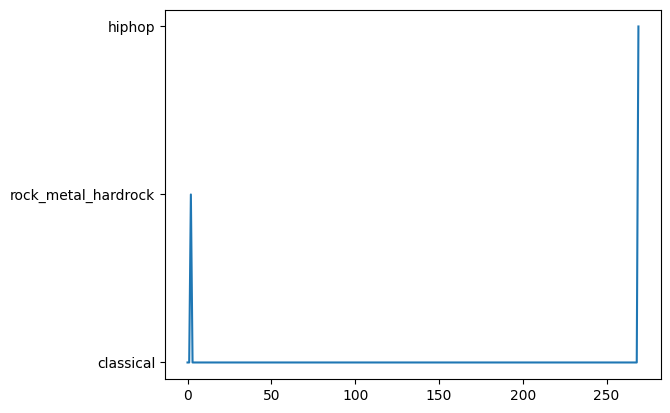

In [ ]:
from torchmetrics.functional import f1_score
def evaluate_model_function(loader,loss_func,neural) :
  neural.eval()
  misclassifications = 0
  correct_predictions = 0
  with torch.no_grad():
    for i , sample in enumerate(loader) :
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music)
      correct_predictions += (output.argmax(1) == label).type(torch.float).sum().item()
      misclassifications += loss_func(output,label).item()

  on_average = misclassifications / len(loader.dataset)
  f1_macro = f1_score(output, label, num_classes=4, average="macro",task = "multiclass")
  accuracy = correct_predictions / len(loader.dataset) * 100
  conf = ConfusionMatrix(num_classes=4,task = "multiclass").to(device)
  matrix = conf(output.argmax(1), label)
  return on_average , f1_macro , accuracy , matrix


def train_model_function2(epochs,optimizer,train_loader,val_loader,loss_func,neural) :
  neural.train()
  best_score = -1
  for epoch in range(epochs) :
    print(" Epoch number is %d",epoch)

    for i , sample in enumerate(train_loader) :
      optimizer.zero_grad()

      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music)
      error = loss_func(output,label)
      error.backward()

      optimizer.step()
    loss , f1 , acc , conf_matrix = evaluate_model_function(val_loader,loss_func,neural)
    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  return wanted,best_epoch

predict("https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano" , "classical")

[youtube] Extracting URL: https://www.youtube.com/watch?v=EDwb9jOVRtU
[youtube] EDwb9jOVRtU: Downloading webpage
[youtube] EDwb9jOVRtU: Downloading ios player API JSON
[youtube] EDwb9jOVRtU: Downloading m3u8 information
[info] EDwb9jOVRtU: Downloading 1 format(s): 251
[download] Destination: temp.webm
[download] 100% of    5.15MiB in 00:00:00 at 63.49MiB/s
[ExtractAudio] Destination: temp.wav
Deleting original file temp.webm (pass -k to keep)
 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is %d 8
 Epoch number is %d 9
 Epoch number is %d 10
 Epoch number is %d 11
 Epoch number is %d 12
 Epoch number is %d 13
 Epoch number is %d 14
 Epoch number is %d 15
 Epoch number is %d 16
 Epoch number is %d 17
 Epoch number is %d 18
 Epoch number is %d 19
 Epoch number is %d 20
 Epoch number is %d 21
 Epoch number is %d 22
 Epoch number is %d 23
 Epoch numb

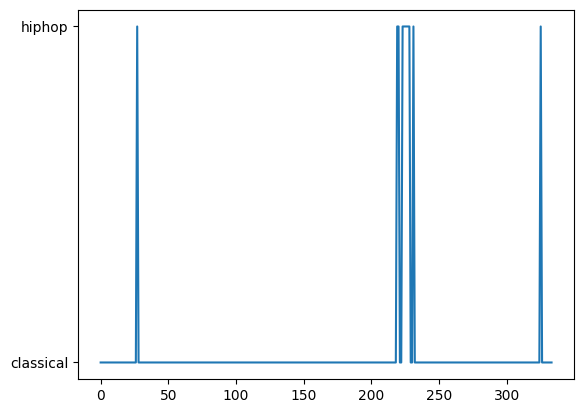

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna
predict("https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna","hiphop")

[youtube] Extracting URL: https://www.youtube.com/watch?v=OMaycNcPsHI
[youtube] OMaycNcPsHI: Downloading webpage
[youtube] OMaycNcPsHI: Downloading ios player API JSON
[youtube] OMaycNcPsHI: Downloading m3u8 information
[info] OMaycNcPsHI: Downloading 1 format(s): 251
[download] Destination: temp.webm
[download] 100% of    3.32MiB in 00:00:00 at 45.81MiB/s
[ExtractAudio] Destination: temp.wav
Deleting original file temp.webm (pass -k to keep)
 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is %d 8
 Epoch number is %d 9
 Epoch number is %d 10
 Epoch number is %d 11
 Epoch number is %d 12
 Epoch number is %d 13
 Epoch number is %d 14
 Epoch number is %d 15
 Epoch number is %d 16
 Epoch number is %d 17
 Epoch number is %d 18
 Epoch number is %d 19
 Epoch number is %d 20
 Epoch number is %d 21
 Epoch number is %d 22
 Epoch number is %d 23
 Epoch numb

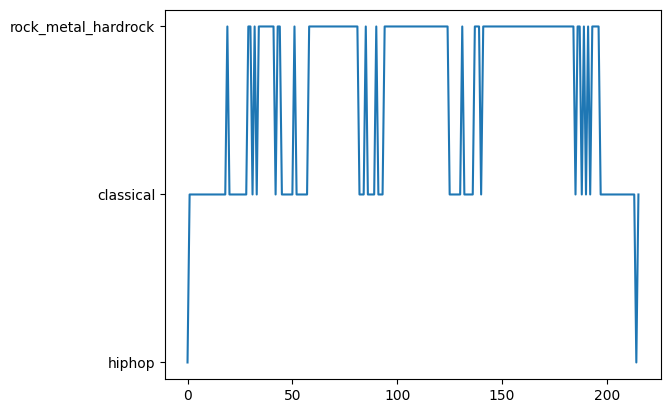

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO
predict("https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO","rock_metal_hardrock")

[youtube] Extracting URL: https://www.youtube.com/watch?v=l45f28PzfCI
[youtube] l45f28PzfCI: Downloading webpage
[youtube] l45f28PzfCI: Downloading ios player API JSON
[youtube] l45f28PzfCI: Downloading m3u8 information
[info] l45f28PzfCI: Downloading 1 format(s): 251
[download] Destination: temp.webm
[download] 100% of    5.26MiB in 00:00:00 at 44.54MiB/s
[ExtractAudio] Destination: temp.wav
Deleting original file temp.webm (pass -k to keep)
 Epoch number is %d 0
 Epoch number is %d 1
 Epoch number is %d 2
 Epoch number is %d 3
 Epoch number is %d 4
 Epoch number is %d 5
 Epoch number is %d 6
 Epoch number is %d 7
 Epoch number is %d 8
 Epoch number is %d 9
 Epoch number is %d 10
 Epoch number is %d 11
 Epoch number is %d 12
 Epoch number is %d 13
 Epoch number is %d 14
 Epoch number is %d 15
 Epoch number is %d 16
 Epoch number is %d 17
 Epoch number is %d 18
 Epoch number is %d 19
 Epoch number is %d 20
 Epoch number is %d 21
 Epoch number is %d 22
 Epoch number is %d 23
 Epoch numb

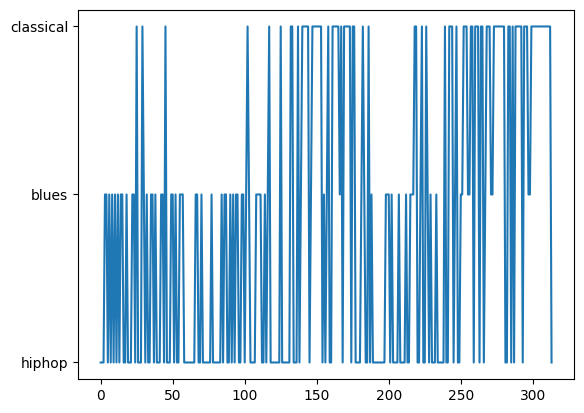

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania
predict("https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania","blues")